In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# t = 100
batch = 50
lr = 1
epochs = 5

In [3]:
# Step 1:
# Training Data:
train_images_file = open('train-images.idx3-ubyte', 'rb')
train_images_file.seek(4)
num_of_train_images = int.from_bytes(train_images_file.read(4), 'big')
train_images_file.seek(16)

train_labels_file = open('train-labels.idx1-ubyte', 'rb')
train_labels_file.seek(8)

8

In [4]:
X_train = []
y_train = []

for n in range(num_of_train_images):
    image = np.zeros((784, 1))
    for i in range(784):
        image[i, 0] = int.from_bytes(train_images_file.read(1), 'big') / 256
    
    label_value = int.from_bytes(train_labels_file.read(1), 'big')
    label = np.zeros((10, 1))
    label[label_value, 0] = 1
    
    X_train.append(image)
    y_train.append(label)
    
X_train = np.array(X_train)
y_train = np.array(y_train)

y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])

In [5]:
# Test Data
test_images_file = open('t10k-images.idx3-ubyte', 'rb')
test_images_file.seek(4)

test_labels_file = open('t10k-labels.idx1-ubyte', 'rb')
test_labels_file.seek(8)

num_of_test_images = int.from_bytes(test_images_file.read(4), 'big')
test_images_file.seek(16)

16

In [6]:
X_test = []
y_test = []

for n in range(num_of_test_images):
    image = np.zeros((784, 1))
    for i in range(784):
        image[i] = int.from_bytes(test_images_file.read(1), 'big') / 256
    
    label_value = int.from_bytes(test_labels_file.read(1), 'big')
    label = np.zeros((10, 1))
    label[label_value, 0] = 1
    
    X_test.append(image)
    y_test.append(label)
    
X_test = np.array(X_test)
y_test = np.array(y_test)

y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [7]:
def show_image(img):
    image = img.reshape((28, 28))
    plt.imshow(image, 'gray')

In [8]:
class NeuralNetwork:
    def __init__(self, X, y):
        self.input = X 
        self.ans = y

        self.x = self.input[:batch] 
        self.y = self.ans[:batch]
        
        self.loss = []
        self.acc = []
        
        self.init_weights()

    # Step 2:
    def init_weights(self):
        self.W1 = np.random.randn(self.input.shape[1],16)
        self.W2 = np.random.randn(self.W1.shape[1],16)
        self.W3 = np.random.randn(self.W2.shape[1],self.y.shape[1])

        self.b1 = np.zeros(self.W1.shape[1],)
        self.b2 = np.zeros(self.W2.shape[1],)
        self.b3 = np.zeros(self.W3.shape[1],)

    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))    

    def d_sigmoid(self, x):
        return (np.exp(-x)) / ((np.exp(-x) + 1) ** 2) 
    
    def softmax(self, z):
        z -= np.max(z, axis = 1).reshape(z.shape[0], 1)
        return np.exp(z) / np.sum(np.exp(z), axis = 1).reshape(z.shape[0], 1)
        
    def feed_forward(self):        
        self.z1 = self.x.dot(self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)

        self.z2 = self.a1.dot(self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)

        self.z3 = self.a2.dot(self.W3) + self.b3
        self.a3 = self.softmax(self.z3)
        self.error = self.a3 - self.y

    # Step 3:
    def back_propagation(self):
        cost = (1 / batch) * self.error
        
        # Step 4:
        GD_W3 = np.dot(cost.T, self.a2).T
        GD_W2 = np.dot((np.dot((cost), self.W3.T) * self.d_sigmoid(self.z2)).T, self.a1).T
        GD_W1 = np.dot((np.dot(np.dot((cost), self.W3.T) * self.d_sigmoid(self.z2), self.W2.T) * self.d_sigmoid(self.z1)).T, self.x).T                

        db3 = np.sum(cost, axis = 0)
        db2 = np.sum(np.dot((cost), self.W3.T) * self.d_sigmoid(self.z2), axis = 0)
        db1 = np.sum((np.dot(np.dot((cost), self.W3.T) * self.d_sigmoid(self.z2), self.W2.T) * self.d_sigmoid(self.z1)), axis = 0)
                
        self.W3 = self.W3 - lr * GD_W3
        self.W2 = self.W2 - lr * GD_W2
        self.W1 = self.W1 - lr * GD_W1
        
        self.b3 = self.b3 - lr * db3
        self.b2 = self.b2 - lr * db2
        self.b1 = self.b1 - lr * db1

    def shuffle(self):
        idx = [i for i in range(self.input.shape[0])]
        np.random.shuffle(idx)
        self.input = self.input[idx]
        self.ans = self.ans[idx]
        
    def train(self):
        start_time = time.time()

        for epoch in range(epochs):
            l = 0
            acc = 0
            self.shuffle()
            
            for bat in range(self.input.shape[0] // batch - 1):
                start = bat * batch
                end = (bat + 1) * batch
                self.x = self.input[start:end]
                self.y = self.ans[start:end]
                self.feed_forward()
                self.back_propagation()
                l += np.mean(self.error ** 2)
                acc += np.count_nonzero(np.argmax(self.a3, axis=1) == np.argmax(self.y, axis=1)) / batch
                
            self.loss.append(l / (self.input.shape[0] // batch))
            self.acc.append(acc * 100 / (self.input.shape[0] // batch))
            
        print(f'Time Spent: {time.time() - start_time} s')
            
    def plot(self):
        plt.figure(dpi = 125)
        plt.plot(self.loss)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
    
    def acc_plot(self):
        plt.figure(dpi = 125)
        plt.plot(self.acc)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        
    def test(self, xt, yt):
        self.x = xt
        self.y = yt
        self.feed_forward()
        
        acc = np.count_nonzero(np.argmax(self.a3, axis=1) == np.argmax(self.y, axis=1)) / self.x.shape[0]
        return acc * 100

Time Spent: 8.884374380111694 s
Test Data Accuracy: 92.2 %
Train Data Accuracy: 92.58333333333333 %


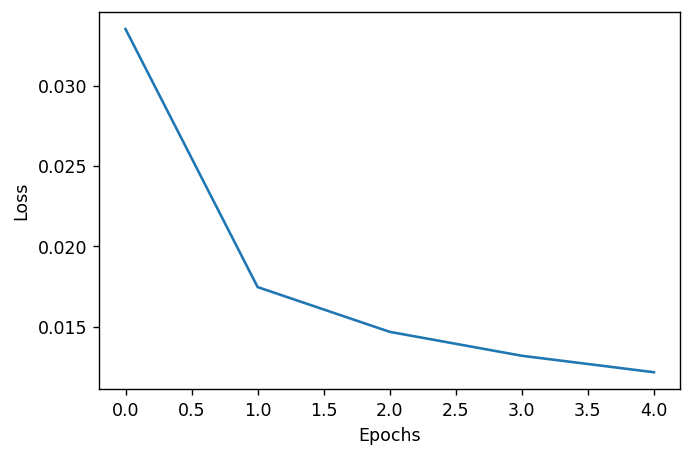

In [9]:
NN = NeuralNetwork(X_train, y_train) 
NN.train()
NN.plot()
print(f"Test Data Accuracy: {NN.test(X_test, y_test)} %")
print(f"Train Data Accuracy: {NN.test(X_train, y_train)} %")

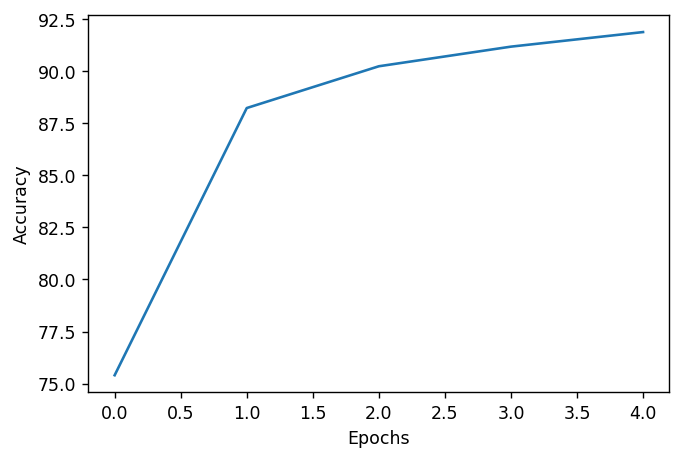

In [10]:
NN.acc_plot()